**EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

*This file includes EXP4 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

In [168]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import biomart
import seaborn as sns

import seaborn as sns
from scipy import stats
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from biomart import BiomartServer
import rpy2 as rpy2
from rpy2.robjects import pandas2ri
from rpy2.robjects import r, globalenv
from rpy2.robjects.packages import importr
# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [169]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [170]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
1,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
2,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
3,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
4,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
5,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
6,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
7,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Dissociated Bulks:

In [171]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,3,0,0,2,0,0,15,0,1,0,...,0,0,19,0,1,1,3,4,39,28
1,1,0,0,5,0,0,63,1,6,0,...,0,0,27,0,0,0,0,0,8,6
2,3,2,0,1,0,0,7,0,5,0,...,0,0,17,0,0,2,0,0,57,30
3,4,0,0,2,0,0,37,0,2,0,...,0,0,2,0,0,0,0,0,10,21
4,2,0,0,4,0,0,31,0,3,0,...,0,0,6,0,0,6,0,0,6,2
5,1,0,0,1,0,0,33,0,2,0,...,0,0,6,0,0,1,0,0,20,16
6,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3
7,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9


Dissociated polyA:

In [172]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,17,2,0,10,0,2,66,0,15,1,...,0,1,35,0,0,9,9,7,56,78
1,2,1,0,7,0,3,134,0,8,0,...,0,4,58,0,1,2,0,0,15,11
2,0,0,0,1,0,0,14,0,10,0,...,0,0,35,0,0,6,0,0,51,27
3,5,1,0,6,0,0,159,0,16,0,...,0,0,2,0,2,6,0,0,27,32
4,4,0,0,13,0,4,92,0,5,0,...,0,0,16,0,0,1,0,0,4,6
5,7,0,0,11,0,9,114,0,12,0,...,0,0,9,0,0,1,0,0,10,17
6,0,0,0,5,0,1,69,0,12,0,...,0,1,33,0,4,30,0,0,6,3
7,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12


And all single-cells:

In [173]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [174]:
#attaching adatas (sc) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [175]:
#Our ground truth in this case is single cell
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

In [176]:
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")

Counter({'Plasma cells': 1432, 'T cells': 506, 'Endothelial cells': 503, 'Fibroblasts': 206, 'Macrophages': 123, 'NK cells': 114, 'B cells': 62, 'Epithelial cells': 56, 'Monocytes': 54, 'ILC': 24, 'DC': 13, 'pDC': 9})
 
Counter({'T cells': 734, 'Epithelial cells': 99, 'NK cells': 67, 'B cells': 41, 'Macrophages': 26, 'Endothelial cells': 18, 'Monocytes': 17, 'Fibroblasts': 13, 'Plasma cells': 13, 'DC': 6, 'pDC': 5})
 
Counter({'Macrophages': 378, 'Fibroblasts': 236, 'Epithelial cells': 236, 'T cells': 142, 'Monocytes': 49, 'NK cells': 26, 'Endothelial cells': 21})
 
Counter({'T cells': 3053, 'NK cells': 459, 'Macrophages': 274, 'Epithelial cells': 184, 'Fibroblasts': 98, 'pDC': 96, 'Plasma cells': 94, 'DC': 29, 'Endothelial cells': 21, 'B cells': 18, 'Monocytes': 3})
 
Counter({'T cells': 720, 'Fibroblasts': 274, 'Endothelial cells': 127, 'Epithelial cells': 118, 'pDC': 60, 'NK cells': 53, 'Monocytes': 38, 'Macrophages': 36, 'B cells': 27, 'ILC': 26, 'Plasma cells': 22, 'DC': 19})
 
Co

Making genes the same in all single-cell datas, and merging.

In [177]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

In [178]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [179]:
#matching index 
bulks.index = range(1,9)
diss_bulks.index = range(1,9)
disspolya_bulks.index = range(1,9)
combo.index = range(1,17)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
1,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
2,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
3,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
4,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
5,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
6,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
7,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
8,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Assigning genes: 

In [180]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
for num in adatas:    
    # read in cibersort genes / cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, f"CIBERSORTx_{res_name}_{bulks_type}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{bulks_type}_{num}missing_signal_inferred_refsample.bm.K999.txt")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [181]:
#From deconv paper:
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]

#adipocyte markers from CellMarker
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [182]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_78271/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adip_markers = np.array(adip_markers)


In [183]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [184]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids

array(['A1BG', 'A2M', 'AAGAB', ..., 'ZSCAN18', 'ZXDC', 'ZYX'],
      dtype=object)

In [185]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

In [186]:
disspolya_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,303,85559,2240,6537,794,9542,2274,1135,3605,3832,...,705,3968,767,508,1059,5164,832,6346,4076,31817
2,145,54188,860,2230,510,8586,1226,394,756,2087,...,200,1754,455,259,340,1218,925,1274,1893,8765
3,123,24366,852,654,673,18826,1375,324,1516,1362,...,359,1057,260,264,463,3104,145,1248,3023,4290
4,83,67865,1607,3890,571,13421,2008,848,2407,2691,...,842,1867,455,420,855,4870,843,937,2007,12246
5,29,26932,1237,1973,196,4404,495,273,1034,1653,...,421,1230,243,264,744,2766,799,941,1253,8728
6,79,22454,1007,1667,255,4221,792,525,1223,1197,...,218,1608,334,300,1162,3483,574,2063,2273,5107
7,69,40836,1118,959,208,9847,889,390,1053,1523,...,252,1382,374,222,61,2642,1147,486,1254,10463
8,55,60905,855,2824,406,10429,1432,1386,1142,2270,...,531,1231,256,236,599,3389,604,1398,2133,8425


Normalizing bulk counts:

In [187]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = range(1, len(combo)+1)
combo

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.030055,1.0,0.204150,0.326818,0.074803,1.0,0.225522,0.043635,0.517387,0.343737,...,0.120442,0.272051,0.069460,0.049201,0.163854,0.292533,0.047642,0.480654,0.397613,1.000000
2,0.033547,1.0,0.220404,0.264924,0.285929,1.0,0.332957,0.010033,0.813582,0.516679,...,0.091548,0.326060,0.089666,0.037622,0.220090,0.316027,0.070542,0.276210,0.763419,0.679082
3,0.036162,1.0,0.200212,0.084671,0.174634,1.0,1.000000,0.018081,1.000000,0.458194,...,0.121715,0.164932,0.097901,0.053360,0.397777,0.300318,0.030429,0.427765,0.802611,0.248280
4,0.006216,1.0,0.206199,0.726840,0.059802,1.0,0.402323,0.105672,0.304583,0.754491,...,0.066232,0.146183,0.058087,0.081022,0.182192,0.461697,0.038368,0.124748,0.202341,0.739915
5,0.017206,1.0,0.333671,0.077598,0.049933,1.0,0.228070,0.031377,1.000000,0.645412,...,0.140688,0.289811,0.109312,0.067139,0.059379,0.281714,0.111336,0.128543,0.534076,0.741903
6,0.073468,1.0,0.313709,0.229955,0.078856,1.0,0.267179,0.097223,0.847088,0.300485,...,0.092815,0.348974,0.089141,0.088897,0.275751,0.421952,0.088162,0.743498,0.506196,0.329137
7,0.007659,1.0,0.244241,0.285090,0.089357,1.0,0.270339,0.108079,0.257574,0.609611,...,0.093044,0.172189,0.050210,0.070918,0.139283,0.446216,0.085102,0.145524,0.249064,1.000000
8,0.020254,1.0,0.181786,0.377576,0.075515,1.0,0.382326,0.080266,0.407832,0.329816,...,0.122525,0.201790,0.075765,0.048510,0.091018,0.230296,0.112022,0.254301,0.450340,0.836167
9,0.040802,1.0,0.173564,0.440537,0.132762,1.0,0.162379,0.107079,0.409884,0.330351,...,0.113086,0.316267,0.059442,0.071869,0.118264,0.399735,0.043494,0.489623,0.342364,1.000000
10,0.028365,1.0,0.153033,0.383807,0.145328,1.0,0.296960,0.100854,0.337932,0.435285,...,0.083345,0.258440,0.076341,0.053579,0.109259,0.235327,0.090349,0.210464,0.411822,0.980529


In [188]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = range(1, len(bulks)+1)
bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.030055,1.0,0.204150,0.326818,0.074803,1.0,0.225522,0.043635,0.517387,0.343737,...,0.120442,0.272051,0.069460,0.049201,0.163854,0.292533,0.047642,0.480654,0.397613,1.000000
2,0.033547,1.0,0.220404,0.264924,0.285929,1.0,0.332957,0.010033,0.813582,0.516679,...,0.091548,0.326060,0.089666,0.037622,0.220090,0.316027,0.070542,0.276210,0.763419,0.679082
3,0.036162,1.0,0.200212,0.084671,0.174634,1.0,1.000000,0.018081,1.000000,0.458194,...,0.121715,0.164932,0.097901,0.053360,0.397777,0.300318,0.030429,0.427765,0.802611,0.248280
4,0.006216,1.0,0.206199,0.726840,0.059802,1.0,0.402323,0.105672,0.304583,0.754491,...,0.066232,0.146183,0.058087,0.081022,0.182192,0.461697,0.038368,0.124748,0.202341,0.739915
5,0.017206,1.0,0.333671,0.077598,0.049933,1.0,0.228070,0.031377,1.000000,0.645412,...,0.140688,0.289811,0.109312,0.067139,0.059379,0.281714,0.111336,0.128543,0.534076,0.741903
6,0.073468,1.0,0.313709,0.229955,0.078856,1.0,0.267179,0.097223,0.847088,0.300485,...,0.092815,0.348974,0.089141,0.088897,0.275751,0.421952,0.088162,0.743498,0.506196,0.329137
7,0.007659,1.0,0.244241,0.285090,0.089357,1.0,0.270339,0.108079,0.257574,0.609611,...,0.093044,0.172189,0.050210,0.070918,0.139283,0.446216,0.085102,0.145524,0.249064,1.000000
8,0.020254,1.0,0.181786,0.377576,0.075515,1.0,0.382326,0.080266,0.407832,0.329816,...,0.122525,0.201790,0.075765,0.048510,0.091018,0.230296,0.112022,0.254301,0.450340,0.836167


In [189]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = range(1, len(diss_bulks)+1)
diss_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.040802,1.0,0.173564,0.440537,0.132762,1.0,0.162379,0.107079,0.409884,0.330351,...,0.113086,0.316267,0.059442,0.071869,0.118264,0.399735,0.043494,0.489623,0.342364,1.000000
2,0.028365,1.0,0.153033,0.383807,0.145328,1.0,0.296960,0.100854,0.337932,0.435285,...,0.083345,0.258440,0.076341,0.053579,0.109259,0.235327,0.090349,0.210464,0.411822,0.980529
3,0.068473,1.0,0.193271,0.180018,0.668532,1.0,0.498822,0.082462,0.655279,0.350464,...,0.143941,0.210573,0.041599,0.119276,0.174128,0.705713,0.027242,0.344942,0.748049,0.603004
4,0.021970,1.0,0.192102,0.426267,0.360894,1.0,0.246222,0.142268,0.451988,0.378041,...,0.144679,0.223449,0.054389,0.108777,0.191298,0.571750,0.049566,0.153788,0.329547,1.000000
5,0.013237,1.0,0.293696,0.410623,0.105896,1.0,0.146986,0.083007,0.377806,0.498042,...,0.229993,0.265843,0.071976,0.101484,0.211516,0.702112,0.124924,0.217032,0.377254,1.000000
6,0.043453,1.0,0.210692,0.306461,0.131504,1.0,0.158090,0.116352,0.391366,0.268439,...,0.079760,0.307890,0.068325,0.152373,0.274157,0.806175,0.075186,0.457690,0.565180,0.689251
7,0.022028,1.0,0.186070,0.157246,0.059524,1.0,0.138733,0.092098,0.258015,0.342145,...,0.092567,0.220988,0.058821,0.070538,0.017576,0.483221,0.122563,0.086005,0.270669,1.000000
8,0.017560,1.0,0.169566,0.449706,0.183834,1.0,0.256544,0.290567,0.305932,0.426933,...,0.189596,0.207979,0.039785,0.081216,0.137464,0.587719,0.072985,0.262855,0.435164,0.855787


In [190]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = range(1, len(diss_bulks)+1)
disspolya_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.022610,1.0,0.167152,0.487799,0.059249,0.712036,0.169689,0.084695,0.269010,0.285949,...,0.052608,0.296097,0.057235,0.037908,0.079024,0.385344,0.062085,0.473547,0.304156,1.0
2,0.028222,1.0,0.167387,0.434038,0.099264,1.000000,0.238624,0.076687,0.147145,0.406205,...,0.038927,0.341391,0.088559,0.050411,0.066176,0.237066,0.180038,0.247966,0.368446,1.0
3,0.028983,1.0,0.200763,0.154107,0.158584,1.000000,0.324002,0.076347,0.357227,0.320939,...,0.084594,0.249069,0.061266,0.062208,0.109100,0.731420,0.034167,0.294076,0.712333,1.0
4,0.010450,1.0,0.202332,0.489776,0.071893,1.000000,0.252820,0.106769,0.303057,0.338814,...,0.106013,0.235067,0.057287,0.052881,0.107650,0.613165,0.106139,0.117974,0.252694,1.0
5,0.006917,1.0,0.295030,0.470569,0.046747,1.000000,0.118060,0.065112,0.246613,0.394247,...,0.100410,0.293360,0.057956,0.062965,0.177447,0.659702,0.190565,0.224432,0.298846,1.0
6,0.016287,1.0,0.207603,0.343669,0.052571,0.870202,0.163279,0.108234,0.252134,0.246774,...,0.044943,0.331505,0.068857,0.061848,0.239558,0.718055,0.118336,0.425308,0.468602,1.0
7,0.012037,1.0,0.195039,0.167301,0.036286,1.000000,0.155089,0.068037,0.183699,0.265692,...,0.043962,0.241094,0.065245,0.038729,0.010642,0.460905,0.200098,0.084784,0.218764,1.0
8,0.009185,1.0,0.142781,0.471594,0.067800,1.000000,0.239137,0.231455,0.190708,0.379079,...,0.088674,0.205571,0.042751,0.039411,0.100030,0.565946,0.100865,0.233459,0.356201,1.0


As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [191]:
Counter(merged_adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [192]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Mast cells", "Erythroid", "Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Fibroblasts' 'ILC'
 'Macrophages' 'Monocytes' 'NK cells' 'Plasma cells' 'T cells' 'pDC']


## References

In [193]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,3055.338135,2785.665283,4300.650391,1607.701172,4996.970215,4770.607910,4250.667480,4269.090332,3718.627441,2868.217285,3189.466064,13838.004883
A2M,6137.494141,1496.519165,1666.122437,95209.664062,1544.643555,4041.959961,2639.286865,28057.558594,1011.243835,4343.418945,11244.426758,595.470947
AAGAB,1661.905762,2926.863525,1483.454102,1750.934326,1803.173218,1543.867432,2208.992676,1411.132568,3011.786621,941.654785,3066.790039,716.381836
AASS,837.118652,444.905701,338.722076,2826.262695,219.165329,671.595703,762.980835,4497.325195,788.600708,0.000000,294.644775,56.071304
AATK,189.700974,2754.353760,126.107651,761.557251,296.031769,698.767822,387.753967,1511.187134,0.000000,599.049561,1288.106689,649.808716
...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1,1025.580933,1360.948486,2739.306152,2544.461182,2346.078125,2660.024902,2971.877197,2051.012207,2165.809082,1688.271973,1960.291382,3777.299072
ZRSR2,1698.244019,2234.578857,5479.795898,2120.978271,5611.209961,1428.797485,3812.186035,2196.223389,5525.742188,2297.045410,3199.317383,1160.098511
ZSCAN18,551.032104,542.546997,821.562256,2706.650146,1722.908447,3556.946289,3640.364014,2640.596436,2735.856445,458.512665,515.068665,411.395935
ZXDC,3104.524170,2163.532959,1935.713379,1447.901855,2189.275391,2080.833008,1592.880371,1225.172241,1806.766235,1688.655151,1768.185791,1725.386353


In [194]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
ref_df_all

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,0.338666,0.308775,0.476702,0.178204,0.553885,0.528794,0.471161,0.473204,0.412188,0.317925,0.353534,1.000000
A2M,0.680305,0.165880,0.184680,1.000000,0.171215,0.448027,0.292549,1.000000,0.112090,0.481442,1.000000,0.066004
AAGAB,0.184212,0.324426,0.164432,0.194081,0.199871,0.171129,0.244854,0.156416,0.333839,0.104377,0.339936,0.079407
AASS,0.092790,0.049315,0.037545,0.313275,0.024293,0.074442,0.084572,0.498502,0.087412,0.000000,0.032660,0.006215
AATK,0.021027,0.305304,0.013978,0.084414,0.032813,0.077454,0.042980,0.167506,0.000000,0.066401,0.142779,0.072027
...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1,0.113680,0.150853,0.303636,0.282039,0.260049,0.294848,0.329415,0.227343,0.240067,0.187135,0.217287,0.418691
ZRSR2,0.188240,0.247690,0.607403,0.235098,0.621970,0.158374,0.422558,0.243438,0.612496,0.254614,0.354625,0.128590
ZSCAN18,0.061079,0.060138,0.091065,0.300016,0.190974,0.394267,0.403513,0.292695,0.303254,0.050823,0.057092,0.045601
ZXDC,0.344118,0.239815,0.214562,0.160491,0.242668,0.230648,0.176561,0.135803,0.200269,0.187177,0.195993,0.191249


## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [195]:
#helper function to calculate nnls and residual
def calc_nnls_simple(all_refs, prop_df, pseudo_df, num_missing_cells):

    calc_prop_tot = pd.DataFrame()
    calc_res_tot = pd.DataFrame()
    custom_res_tot = pd.DataFrame()
    comparison_prop_tot = pd.DataFrame()
    missing_cell_tot = pd.DataFrame()

    for idx, bulk in pseudo_df.iterrows():

        calc_prop_all = pd.DataFrame()
        custom_res_all = pd.DataFrame()
        calc_res_all  = pd.DataFrame()

        print(f"Sample No.:{idx}")

        #extracting reference with missing cells 
        ref = all_refs.values

        #using SC reference with each matching bulk
        calc_prop, calc_res = nnls(ref, bulk.values)

        #putting values in proportion format
        tot = np.sum(calc_prop) #putting them in proportion format
        calc_prop = calc_prop / tot

        #rebalancing the proportions
        # prop = prop_df[idx]["Prop_Cells"].values #extracting correct proportion
        # total_prop = np.sum(prop)
        # balanced_prop = prop / total_prop
        
        #putting together
        calc_prop_all = pd.concat([pd.DataFrame(calc_prop_all), pd.DataFrame(calc_prop)])
        calc_res_all  = np.append(calc_res_all, calc_res)
            
        #attaching to dataframes
        calc_prop_tot[idx] = calc_prop_all
        calc_prop_tot[idx].columns = all_refs.columns
        calc_prop_tot[idx].index = range(0,len(calc_prop_tot[idx]))
        calc_res_tot[idx] = calc_res_all


    calc_prop_tot = calc_prop_tot.T
    cals_res_tot = calc_res_tot.T
    calc_prop_tot.columns = all_refs.columns

    return calc_prop_tot, calc_res_tot, 

In [196]:
all_refs = ref_df_all.copy()
all_refs

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,0.338666,0.308775,0.476702,0.178204,0.553885,0.528794,0.471161,0.473204,0.412188,0.317925,0.353534,1.000000
A2M,0.680305,0.165880,0.184680,1.000000,0.171215,0.448027,0.292549,1.000000,0.112090,0.481442,1.000000,0.066004
AAGAB,0.184212,0.324426,0.164432,0.194081,0.199871,0.171129,0.244854,0.156416,0.333839,0.104377,0.339936,0.079407
AASS,0.092790,0.049315,0.037545,0.313275,0.024293,0.074442,0.084572,0.498502,0.087412,0.000000,0.032660,0.006215
AATK,0.021027,0.305304,0.013978,0.084414,0.032813,0.077454,0.042980,0.167506,0.000000,0.066401,0.142779,0.072027
...,...,...,...,...,...,...,...,...,...,...,...,...
ZPR1,0.113680,0.150853,0.303636,0.282039,0.260049,0.294848,0.329415,0.227343,0.240067,0.187135,0.217287,0.418691
ZRSR2,0.188240,0.247690,0.607403,0.235098,0.621970,0.158374,0.422558,0.243438,0.612496,0.254614,0.354625,0.128590
ZSCAN18,0.061079,0.060138,0.091065,0.300016,0.190974,0.394267,0.403513,0.292695,0.303254,0.050823,0.057092,0.045601
ZXDC,0.344118,0.239815,0.214562,0.160491,0.242668,0.230648,0.176561,0.135803,0.200269,0.187177,0.195993,0.191249


In [197]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = calc_nnls_simple(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:1
Sample No.:2
Sample No.:3
Sample No.:4
Sample No.:5
Sample No.:6
Sample No.:7
Sample No.:8


In [198]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = calc_nnls_simple(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:1
Sample No.:2
Sample No.:3
Sample No.:4
Sample No.:5
Sample No.:6
Sample No.:7
Sample No.:8


In [199]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = calc_nnls_simple(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:1
Sample No.:2
Sample No.:3
Sample No.:4
Sample No.:5
Sample No.:6
Sample No.:7
Sample No.:8


In [200]:
#combination
calc_prop_tot_combo, calc_res_tot_combo = calc_nnls_simple(all_refs, prop_df, combo, num_missing_cells = [0,1])

Sample No.:1
Sample No.:2
Sample No.:3
Sample No.:4
Sample No.:5
Sample No.:6
Sample No.:7
Sample No.:8
Sample No.:9
Sample No.:10
Sample No.:11
Sample No.:12
Sample No.:13
Sample No.:14
Sample No.:15
Sample No.:16


## Evalutating NNLS Performance:

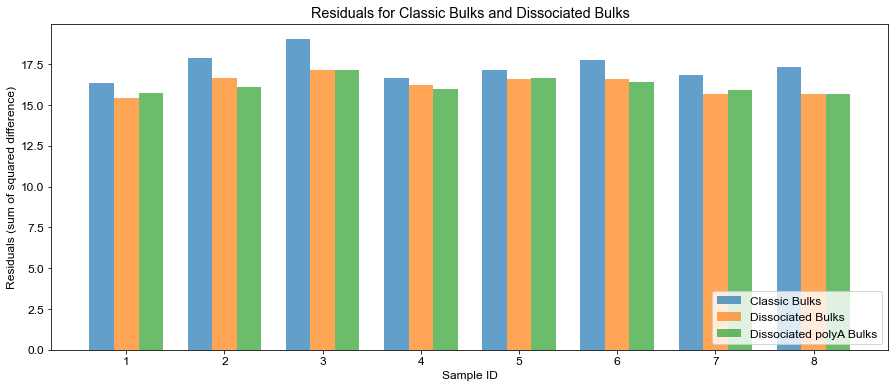

In [201]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=0.7, label='Classic Bulks')

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.7, label='Dissociated Bulks')

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=0.7, label='Dissociated polyA Bulks')

plt.xlabel('Sample ID')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Classic Bulks and Dissociated Bulks')
plt.xticks(x_coordinates + bar_width, x_coordinates + 1)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

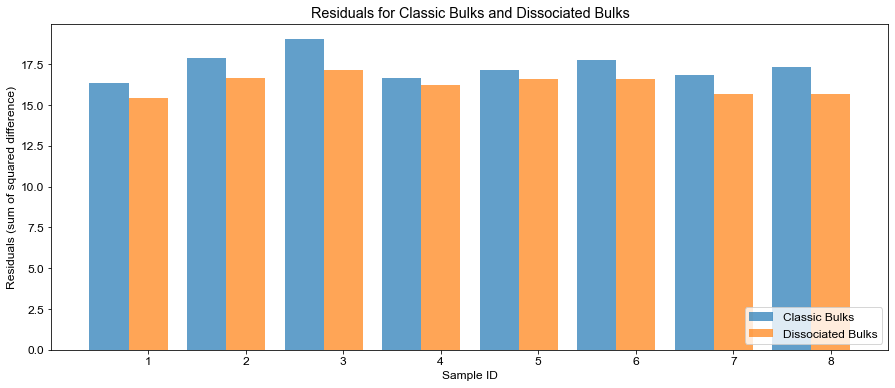

In [202]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.4

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=0.7, label='Classic Bulks')

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.7, label='Dissociated Bulks')

plt.xlabel('Sample ID')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Classic Bulks and Dissociated Bulks')
plt.xticks(x_coordinates + bar_width, x_coordinates + 1)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

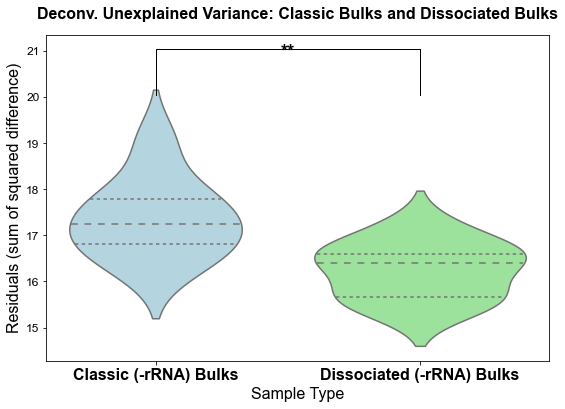

In [203]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max(classic_bulks_values)+1, max(classic_bulks_values) +2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(.5, max(df['Residuals']), f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
#plt.ylim(14.5, 24)
plt.show()

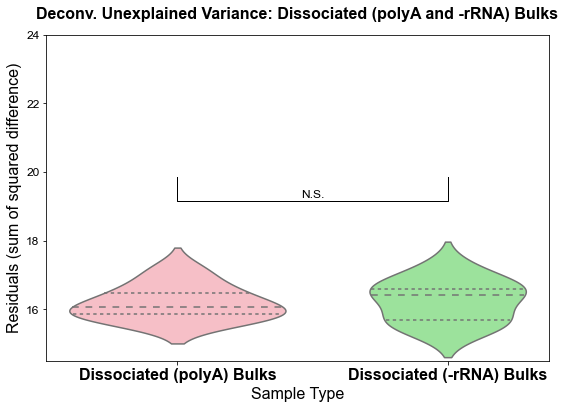

In [204]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_disspolyabulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 10, max(df['Residuals']) + 2.8
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 19.85, max(df['Residuals']) + 2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(.5, max(df['Residuals']), f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14.5, 24)
plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [205]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.451095,0.761373,0.180449,0.259021,0.107716,0.859168,0.192581,0.070155,0.346973,0.475454,...,0.179102,0.931027,0.280723,0.413658,0.201565,0.228218,0.221402,0.267453,0.207022,0.757584
2,0.459788,0.612963,0.192062,0.121037,0.080896,0.757425,0.147773,0.062059,0.367601,0.519591,...,0.170491,0.926172,0.272141,0.432847,0.175375,0.242497,0.201908,0.278025,0.238797,0.732736
3,0.453792,0.579675,0.199106,0.114435,0.072658,0.745837,0.161884,0.064691,0.371412,0.506303,...,0.189916,0.882596,0.265637,0.423947,0.168478,0.237042,0.222769,0.271815,0.242571,0.682234
4,0.355724,0.913514,0.198145,0.345430,0.144072,0.880327,0.192768,0.239015,0.297000,0.520193,...,0.176136,0.981429,0.257162,0.410332,0.187585,0.229784,0.247516,0.242898,0.168431,0.903573
5,0.422458,0.730410,0.253459,0.056498,0.100075,0.826356,0.166515,0.046358,0.306085,0.452368,...,0.180662,0.955956,0.249318,0.385629,0.128919,0.235139,0.263764,0.191008,0.228380,0.841192
6,0.445241,0.701120,0.182649,0.197831,0.095585,0.781165,0.151508,0.093097,0.358407,0.537005,...,0.159033,0.948949,0.281458,0.441686,0.189406,0.243813,0.203152,0.287257,0.217141,0.786979
7,0.346532,0.860565,0.227410,0.266965,0.149874,0.904055,0.195374,0.199823,0.278625,0.472020,...,0.175741,0.973486,0.233352,0.377248,0.159422,0.218515,0.260021,0.196418,0.184806,0.899686
8,0.394931,0.867085,0.217971,0.234443,0.107619,0.977762,0.258982,0.075298,0.348126,0.377053,...,0.197062,0.873513,0.224689,0.339208,0.178912,0.188953,0.265886,0.158745,0.220702,0.690230


In [206]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.420185,0.828950,0.172932,0.304724,0.111071,0.866928,0.196230,0.132761,0.355013,0.502957,...,0.169839,0.938454,0.273138,0.419861,0.209468,0.226032,0.217156,0.265633,0.198349,0.777407
2,0.368630,0.922863,0.216755,0.252165,0.114223,0.943851,0.233690,0.150993,0.336648,0.437848,...,0.185075,0.921188,0.228417,0.363878,0.177008,0.204774,0.258334,0.175603,0.205350,0.777895
3,0.410955,0.722625,0.192935,0.171088,0.084586,0.817395,0.180010,0.122733,0.381137,0.507299,...,0.166109,0.908710,0.244771,0.411198,0.180696,0.223169,0.210179,0.237872,0.235400,0.716665
4,0.356425,0.889223,0.198173,0.318905,0.133489,0.896821,0.206291,0.220218,0.318605,0.496231,...,0.176847,0.952003,0.242563,0.395435,0.187135,0.217754,0.242827,0.223057,0.185623,0.839771
5,0.379256,0.776661,0.218304,0.174019,0.099920,0.818721,0.183090,0.187069,0.333617,0.505980,...,0.194299,0.933495,0.237572,0.400584,0.159011,0.231026,0.245041,0.221982,0.215185,0.791326
6,0.429467,0.746036,0.178925,0.231999,0.097583,0.814580,0.172127,0.116812,0.365037,0.523080,...,0.163759,0.935472,0.271237,0.430050,0.196232,0.233572,0.207063,0.272619,0.214960,0.764674
7,0.379001,0.864167,0.255826,0.141586,0.110849,0.903069,0.238585,0.119620,0.281876,0.376515,...,0.219510,0.940022,0.235777,0.347488,0.127260,0.209737,0.322638,0.118056,0.213203,0.814632
8,0.316263,0.888748,0.196157,0.250996,0.086369,0.863155,0.222009,0.295978,0.392886,0.524985,...,0.183368,0.886332,0.200458,0.391059,0.182024,0.205138,0.232018,0.192126,0.222286,0.706305


In [207]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.424080,0.832516,0.172108,0.314175,0.115679,0.846988,0.183129,0.140012,0.343096,0.523085,...,0.168183,0.958075,0.284821,0.433103,0.209477,0.235899,0.217690,0.283001,0.188914,0.817385
2,0.369991,0.948274,0.221057,0.273922,0.128859,0.904532,0.204868,0.175195,0.300036,0.481003,...,0.182965,0.972099,0.252747,0.390216,0.172399,0.227540,0.266387,0.208238,0.179983,0.887773
3,0.413676,0.709831,0.196357,0.158647,0.086276,0.781152,0.159019,0.131795,0.368653,0.535654,...,0.163360,0.930827,0.255237,0.427399,0.174692,0.236305,0.210460,0.255702,0.228970,0.762439
4,0.346054,0.881285,0.205405,0.313325,0.141369,0.881874,0.194545,0.239609,0.301440,0.509004,...,0.175476,0.968284,0.242134,0.398975,0.178358,0.223096,0.246870,0.225090,0.179917,0.880065
5,0.387408,0.746652,0.217036,0.172787,0.107323,0.793486,0.162175,0.179043,0.321014,0.525984,...,0.183813,0.955262,0.249384,0.414798,0.157418,0.240242,0.238649,0.241362,0.209705,0.833429
6,0.436768,0.753427,0.178767,0.246125,0.105729,0.786234,0.152094,0.123809,0.344263,0.551517,...,0.161335,0.967392,0.290103,0.449562,0.195688,0.248958,0.209140,0.298614,0.199651,0.830085
7,0.388481,0.881852,0.258556,0.152147,0.120260,0.906184,0.223160,0.118249,0.271324,0.392978,...,0.216785,0.962313,0.242750,0.358515,0.130785,0.217945,0.315109,0.140985,0.202948,0.869984
8,0.304612,0.902931,0.191738,0.275795,0.090754,0.830813,0.206747,0.343911,0.384187,0.565530,...,0.182203,0.906627,0.208195,0.410631,0.183481,0.216380,0.230687,0.214263,0.209768,0.751112


In [208]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
1,0.451095,0.761373,0.180449,0.259021,0.107716,0.859168,0.192581,0.070155,0.346973,0.475454,...,0.179102,0.931027,0.280723,0.413658,0.201565,0.228218,0.221402,0.267453,0.207022,0.757584
2,0.459788,0.612963,0.192062,0.121037,0.080896,0.757425,0.147773,0.062059,0.367601,0.519591,...,0.170491,0.926172,0.272141,0.432847,0.175375,0.242497,0.201908,0.278025,0.238797,0.732736
3,0.453792,0.579675,0.199106,0.114435,0.072658,0.745837,0.161884,0.064691,0.371412,0.506303,...,0.189916,0.882596,0.265637,0.423947,0.168478,0.237042,0.222769,0.271815,0.242571,0.682234
4,0.355724,0.913514,0.198145,0.345430,0.144072,0.880327,0.192768,0.239015,0.297000,0.520193,...,0.176136,0.981429,0.257162,0.410332,0.187585,0.229784,0.247516,0.242898,0.168431,0.903573
5,0.422458,0.730410,0.253459,0.056498,0.100075,0.826356,0.166515,0.046358,0.306085,0.452368,...,0.180662,0.955956,0.249318,0.385629,0.128919,0.235139,0.263764,0.191008,0.228380,0.841192
6,0.445241,0.701120,0.182649,0.197831,0.095585,0.781165,0.151508,0.093097,0.358407,0.537005,...,0.159033,0.948949,0.281458,0.441686,0.189406,0.243813,0.203152,0.287257,0.217141,0.786979
7,0.346532,0.860565,0.227410,0.266965,0.149874,0.904055,0.195374,0.199823,0.278625,0.472020,...,0.175741,0.973486,0.233352,0.377248,0.159422,0.218515,0.260021,0.196418,0.184806,0.899686
8,0.394931,0.867085,0.217971,0.234443,0.107619,0.977762,0.258982,0.075298,0.348126,0.377053,...,0.197062,0.873513,0.224689,0.339208,0.178912,0.188953,0.265886,0.158745,0.220702,0.690230
9,0.420185,0.828950,0.172932,0.304724,0.111071,0.866928,0.196230,0.132761,0.355013,0.502957,...,0.169839,0.938454,0.273138,0.419861,0.209468,0.226032,0.217156,0.265633,0.198349,0.777407
10,0.368630,0.922863,0.216755,0.252165,0.114223,0.943851,0.233690,0.150993,0.336648,0.437848,...,0.185075,0.921188,0.228417,0.363878,0.177008,0.204774,0.258334,0.175603,0.205350,0.777895


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [209]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns)
residuals_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,-0.421040,0.238627,0.023701,0.067797,-0.032913,0.140832,0.032941,-0.026520,0.170414,-0.131716,...,-0.058660,-0.658976,-0.211263,-0.364458,-0.037711,0.064315,-0.173760,0.213200,0.190591,0.242416
1,-0.426242,0.387037,0.028342,0.143887,0.205033,0.242575,0.185184,-0.052027,0.445980,-0.002912,...,-0.078943,-0.600113,-0.182474,-0.395225,0.044716,0.073530,-0.131366,-0.001815,0.524622,-0.053654
2,-0.417630,0.420325,0.001106,-0.029764,0.101976,0.254163,0.838116,-0.046610,0.628588,-0.048110,...,-0.068202,-0.717664,-0.167736,-0.370586,0.229300,0.063276,-0.192340,0.155950,0.560040,-0.433953
3,-0.349508,0.086486,0.008054,0.381410,-0.084270,0.119673,0.209555,-0.133343,0.007583,0.234297,...,-0.109904,-0.835246,-0.199075,-0.329310,-0.005392,0.231913,-0.209149,-0.118149,0.033910,-0.163658
4,-0.405251,0.269590,0.080212,0.021100,-0.050143,0.173644,0.061555,-0.014982,0.693915,0.193044,...,-0.039973,-0.666145,-0.140006,-0.318490,-0.069539,0.046575,-0.152427,-0.062466,0.305696,-0.099289
5,-0.371773,0.298880,0.131060,0.032124,-0.016729,0.218835,0.115671,0.004126,0.488681,-0.236520,...,-0.066219,-0.599975,-0.192316,-0.352789,0.086344,0.178139,-0.114990,0.456242,0.289055,-0.457842
6,-0.338873,0.139435,0.016831,0.018125,-0.060518,0.095945,0.074966,-0.091744,-0.021051,0.137591,...,-0.082696,-0.801297,-0.183142,-0.306330,-0.020139,0.227701,-0.174919,-0.050895,0.064258,0.100314
7,-0.374677,0.132915,-0.036185,0.143132,-0.032104,0.022238,0.123344,0.004968,0.059705,-0.047237,...,-0.074537,-0.671723,-0.148924,-0.290698,-0.087894,0.041343,-0.153864,0.095556,0.229638,0.145938


In [210]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns)
residuals_dissbulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,-0.379384,0.171050,0.000632,0.135813,0.021691,0.133072,-0.033851,-0.025682,0.054871,-0.172606,...,-0.056753,-0.622187,-0.213696,-0.347991,-0.091205,0.173703,-0.173662,0.223991,0.144015,0.222593
1,-0.340265,0.077137,-0.063722,0.131642,0.031105,0.056149,0.063270,-0.050139,0.001285,-0.002563,...,-0.101730,-0.662749,-0.152076,-0.310299,-0.067749,0.030553,-0.167986,0.034860,0.206473,0.202635
2,-0.342482,0.277375,0.000335,0.008930,0.583946,0.182605,0.318812,-0.040271,0.274142,-0.156835,...,-0.022168,-0.698137,-0.203172,-0.291922,-0.006569,0.482545,-0.182937,0.107070,0.512649,-0.113661
3,-0.334455,0.110777,-0.006071,0.107362,0.227404,0.103179,0.039931,-0.077950,0.133383,-0.118190,...,-0.032168,-0.728554,-0.188175,-0.286658,0.004163,0.353996,-0.193262,-0.069268,0.143924,0.160229
4,-0.366019,0.223339,0.075392,0.236604,0.005976,0.181279,-0.036104,-0.104062,0.044189,-0.007938,...,0.035694,-0.667652,-0.165595,-0.299100,0.052505,0.471086,-0.120117,-0.004950,0.162069,0.208674
5,-0.386013,0.253964,0.031767,0.074462,0.033921,0.185420,-0.014036,-0.000460,0.026330,-0.254640,...,-0.083999,-0.627582,-0.202913,-0.277678,0.077925,0.572603,-0.131877,0.185071,0.350220,-0.075423
6,-0.356973,0.135833,-0.069756,0.015660,-0.051325,0.096931,-0.099852,-0.027522,-0.023861,-0.034370,...,-0.126943,-0.719034,-0.176957,-0.276950,-0.109685,0.273484,-0.200075,-0.032051,0.057466,0.185368
7,-0.298703,0.111252,-0.026591,0.198710,0.097465,0.136845,0.034535,-0.005411,-0.086954,-0.098052,...,0.006228,-0.678353,-0.160673,-0.309843,-0.044560,0.382580,-0.159033,0.070728,0.212879,0.149482


In [211]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns)
residuals_disspolyabulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,-0.401470,0.167484,-0.004956,0.173625,-0.056430,-0.134951,-0.013440,-0.055317,-0.074086,-0.237137,...,-0.115575,-0.661977,-0.227586,-0.395195,-0.130453,0.149445,-0.155605,0.190546,0.115243,0.182615
1,-0.341769,0.051726,-0.053670,0.160116,-0.029595,0.095468,0.033756,-0.098508,-0.152891,-0.074798,...,-0.144038,-0.630708,-0.164188,-0.339805,-0.106223,0.009527,-0.086349,0.039728,0.188463,0.112227
2,-0.384692,0.290169,0.004406,-0.004540,0.072309,0.218848,0.164983,-0.055449,-0.011426,-0.214715,...,-0.078766,-0.681758,-0.193971,-0.365190,-0.065592,0.495115,-0.176292,0.038374,0.483363,0.237561
3,-0.335604,0.118715,-0.003074,0.176452,-0.069476,0.118126,0.058275,-0.132840,0.001617,-0.170189,...,-0.069463,-0.733216,-0.184847,-0.346094,-0.070708,0.390069,-0.140730,-0.107115,0.072777,0.119935
4,-0.380491,0.253348,0.077994,0.297781,-0.060576,0.206514,-0.044115,-0.113932,-0.074401,-0.131736,...,-0.083403,-0.661902,-0.191427,-0.351833,0.020029,0.419461,-0.048084,-0.016930,0.089141,0.166571
5,-0.420482,0.246573,0.028837,0.097544,-0.053158,0.083968,0.011184,-0.015575,-0.092129,-0.304744,...,-0.116392,-0.635886,-0.221246,-0.387714,0.043869,0.469097,-0.090804,0.126695,0.268951,0.169915
6,-0.376443,0.118148,-0.063517,0.015153,-0.083973,0.093816,-0.068071,-0.050212,-0.087625,-0.127286,...,-0.172823,-0.721219,-0.177504,-0.319787,-0.120143,0.242960,-0.115012,-0.056201,0.015817,0.130016
7,-0.295428,0.097069,-0.048957,0.195799,-0.022954,0.169187,0.032390,-0.112456,-0.193479,-0.186451,...,-0.093528,-0.701056,-0.165444,-0.371220,-0.083451,0.349567,-0.129822,0.019196,0.146432,0.248888


In [212]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,-0.421040,0.238627,0.023701,0.067797,-0.032913,0.140832,0.032941,-0.026520,0.170414,-0.131716,...,-0.058660,-0.658976,-0.211263,-0.364458,-0.037711,0.064315,-0.173760,0.213200,0.190591,0.242416
1,-0.426242,0.387037,0.028342,0.143887,0.205033,0.242575,0.185184,-0.052027,0.445980,-0.002912,...,-0.078943,-0.600113,-0.182474,-0.395225,0.044716,0.073530,-0.131366,-0.001815,0.524622,-0.053654
2,-0.417630,0.420325,0.001106,-0.029764,0.101976,0.254163,0.838116,-0.046610,0.628588,-0.048110,...,-0.068202,-0.717664,-0.167736,-0.370586,0.229300,0.063276,-0.192340,0.155950,0.560040,-0.433953
3,-0.349508,0.086486,0.008054,0.381410,-0.084270,0.119673,0.209555,-0.133343,0.007583,0.234297,...,-0.109904,-0.835246,-0.199075,-0.329310,-0.005392,0.231913,-0.209149,-0.118149,0.033910,-0.163658
4,-0.405251,0.269590,0.080212,0.021100,-0.050143,0.173644,0.061555,-0.014982,0.693915,0.193044,...,-0.039973,-0.666145,-0.140006,-0.318490,-0.069539,0.046575,-0.152427,-0.062466,0.305696,-0.099289
5,-0.371773,0.298880,0.131060,0.032124,-0.016729,0.218835,0.115671,0.004126,0.488681,-0.236520,...,-0.066219,-0.599975,-0.192316,-0.352789,0.086344,0.178139,-0.114990,0.456242,0.289055,-0.457842
6,-0.338873,0.139435,0.016831,0.018125,-0.060518,0.095945,0.074966,-0.091744,-0.021051,0.137591,...,-0.082696,-0.801297,-0.183142,-0.306330,-0.020139,0.227701,-0.174919,-0.050895,0.064258,0.100314
7,-0.374677,0.132915,-0.036185,0.143132,-0.032104,0.022238,0.123344,0.004968,0.059705,-0.047237,...,-0.074537,-0.671723,-0.148924,-0.290698,-0.087894,0.041343,-0.153864,0.095556,0.229638,0.145938
8,-0.379384,0.171050,0.000632,0.135813,0.021691,0.133072,-0.033851,-0.025682,0.054871,-0.172606,...,-0.056753,-0.622187,-0.213696,-0.347991,-0.091205,0.173703,-0.173662,0.223991,0.144015,0.222593
9,-0.340265,0.077137,-0.063722,0.131642,0.031105,0.056149,0.063270,-0.050139,0.001285,-0.002563,...,-0.101730,-0.662749,-0.152076,-0.310299,-0.067749,0.030553,-0.167986,0.034860,0.206473,0.202635


## Comparing Residuals

In [213]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

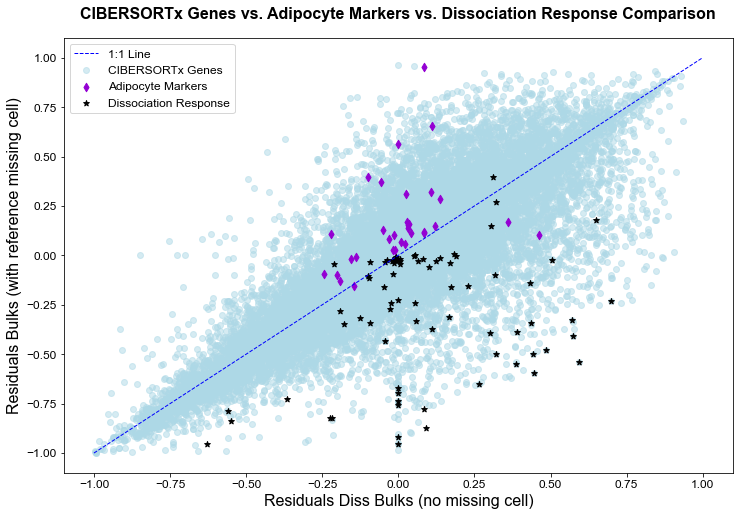

In [214]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(12, 8))

# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', label='CIBERSORTx Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('CIBERSORTx Genes vs. Adipocyte Markers vs. Dissociation Response Comparison', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residuals Bulks (with reference missing cell)', fontsize=16, fontname='Arial')
plt.xlabel('Residuals Diss Bulks (no missing cell)', fontsize=16, fontname='Arial')


# Add legend
plt.legend()

# Show the plot
plt.show()

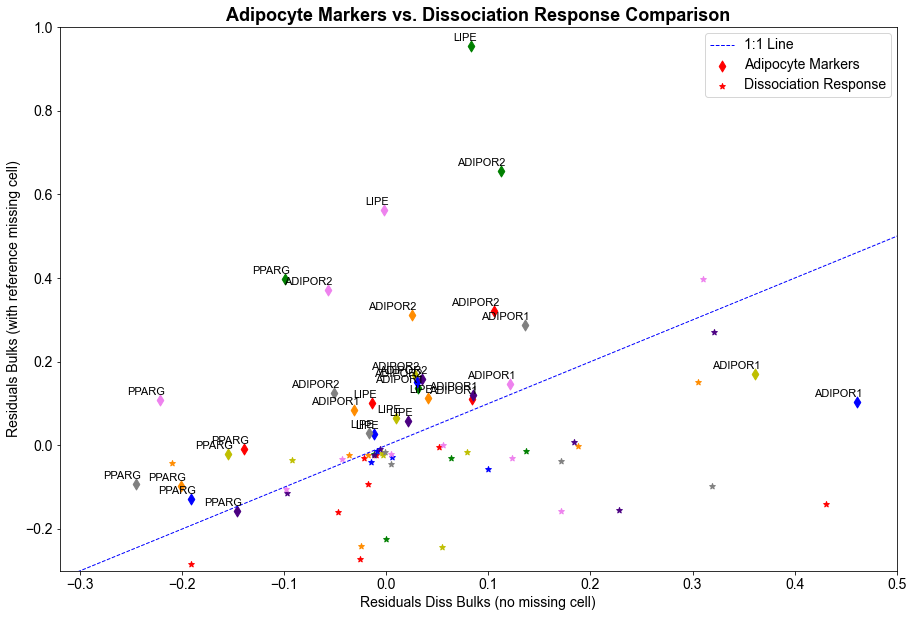

In [215]:
# Assuming `row_indices` contains the row indices of your samples
row_indices = np.tile(range(1, 9), 2)

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(residuals_bulks)))

# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:
        gene_data_bulks = residuals_bulks.at[sample_idx, gene]
        gene_data_dissbulks = residuals_dissbulks.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = residuals_bulks.at[sample_idx, gene]
        gene_data_dissbulks = residuals_dissbulks.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers vs. Dissociation Response Comparison', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residuals Bulks (with reference missing cell)', fontsize=14, fontname='Arial')
plt.xlabel('Residuals Diss Bulks (no missing cell)', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')

# Show the plot
plt.show()


# Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

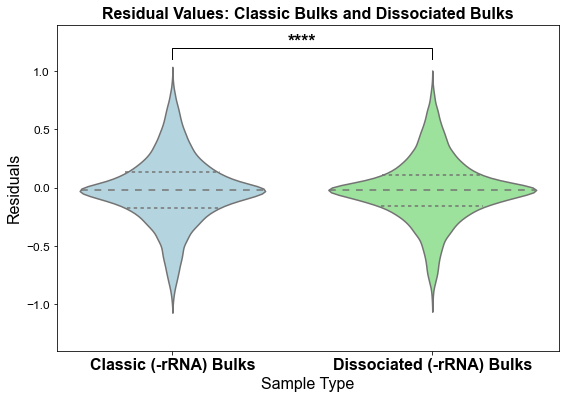

In [216]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1, 1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.5, .65, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

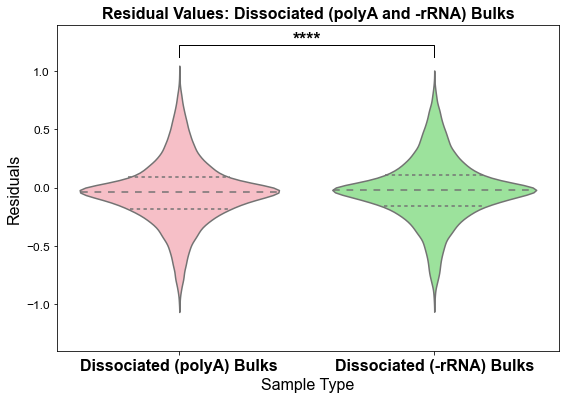

In [217]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
disspolya_bulks_values = residuals_disspolyabulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(disspolya_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([disspolya_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(disspolya_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.12, 1.22  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results    
    x1, x2 = 0, 1
    y1, y2 = 1.12, 1.22  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, "N.S", ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Dissociated (polyA and -rRNA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

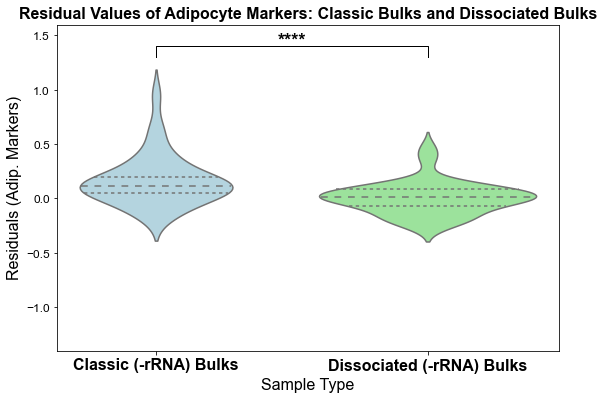

In [218]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.2, 0.9, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

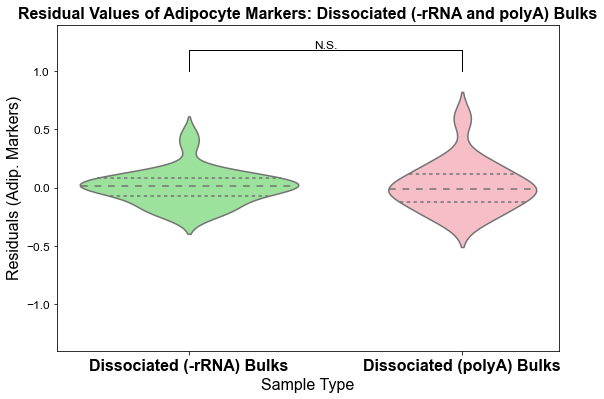

In [219]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.2  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1,1.18
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Dissociated (-rRNA and polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

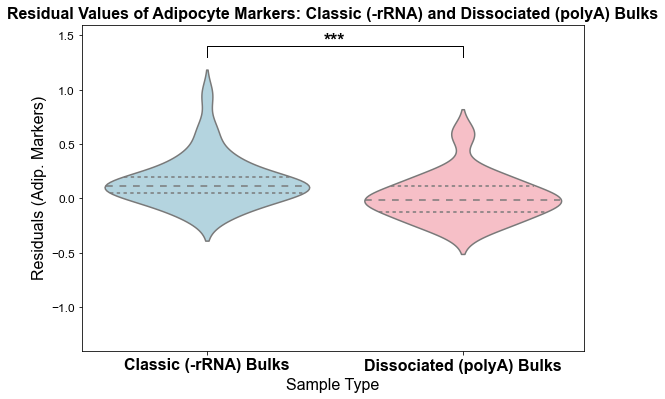

In [220]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Classic (-rRNA) and Dissociated (polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

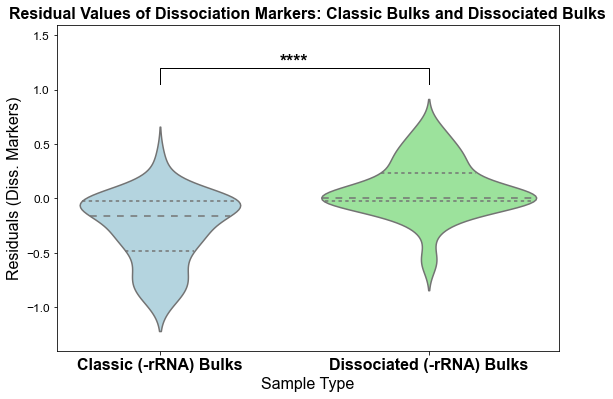

In [221]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Diss. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.05, 1.2  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)} (p < 0.05)"
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.2, 0.9, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


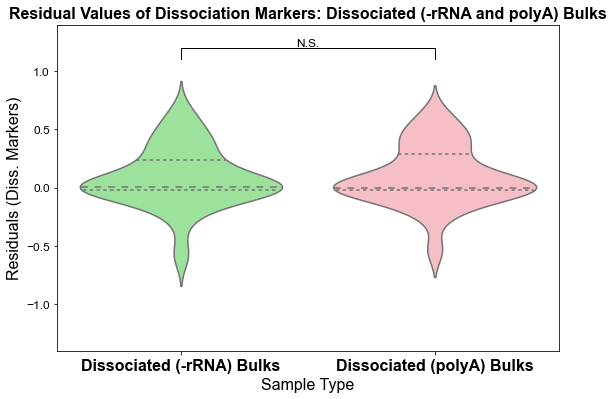

In [222]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.2  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1,1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Dissociated (-rRNA and polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

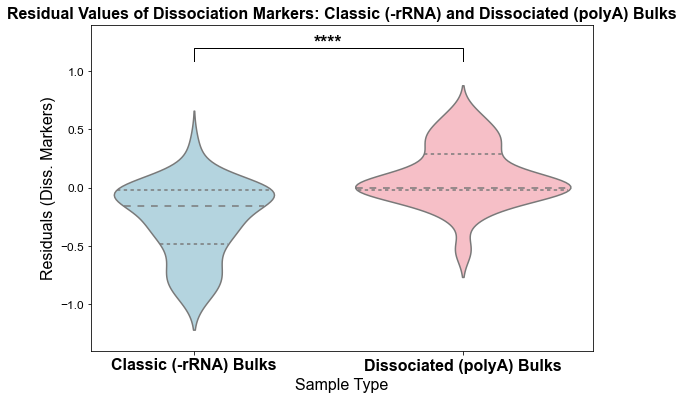

In [223]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Diss. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.09, 1.2 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1, 1.1
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Classic (-rRNA) and Dissociated (polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

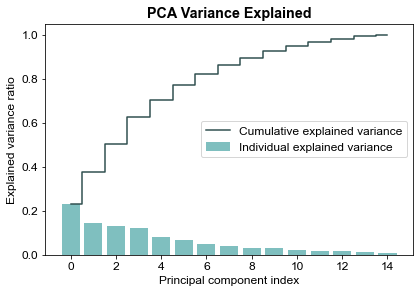

In [224]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 15
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()



In [225]:
# Separate the first and last 8 samples
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

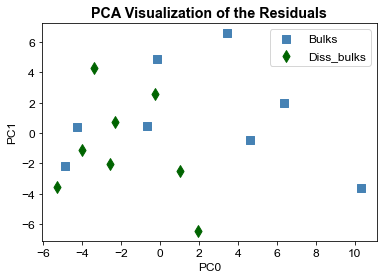

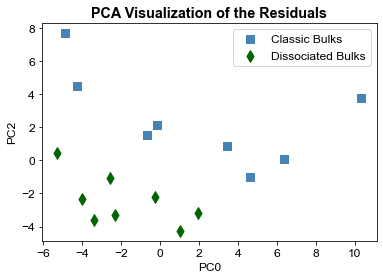

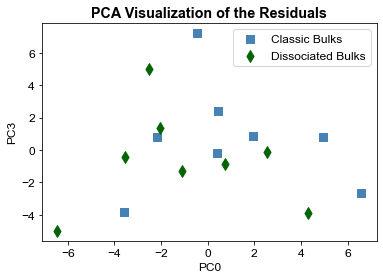

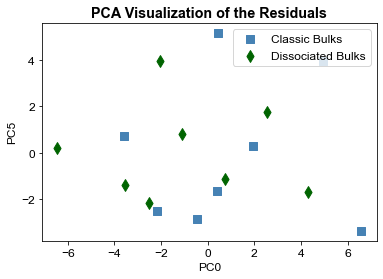

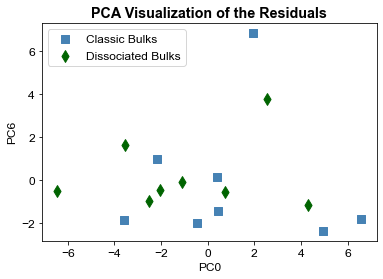

In [226]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



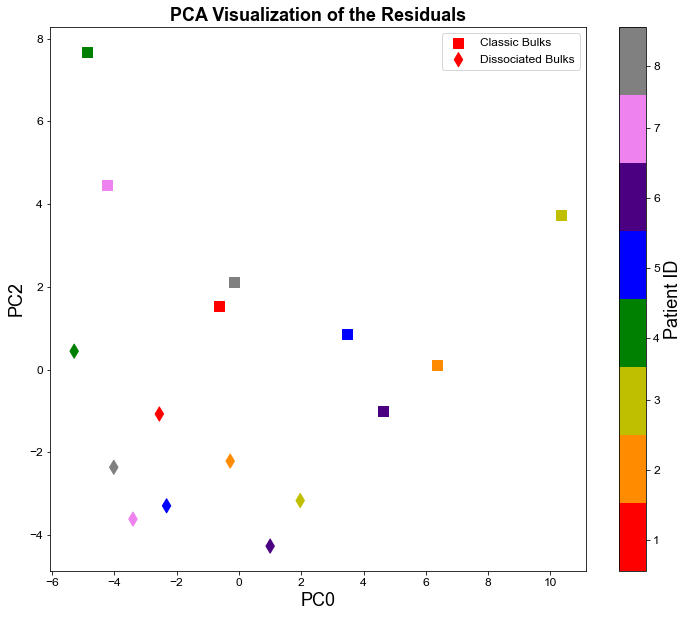

In [227]:
# Assuming `row_indices` contains the row indices of your samples
row_indices = np.tile(range(1, 9), 2)
plt.figure(figsize = (12,10))
# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# PCA Visualization
scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                            cmap=cmap_custom, marker='s', s=marker_size)
scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                            cmap=cmap_custom, marker='d', s=marker_size)

# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Patient ID', fontsize=18)

# Adjust colorbar ticks to be centered between colors
cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
cbar.set_ticklabels([1,2,3,4,5,6,7,8])

# Change the color of the little marker in the legend
# Change the color of the marker in the legend using a custom handler
legend = plt.legend()

plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=18, fontname='Arial')
plt.xlabel("PC0", fontsize=18, fontname='Arial')
plt.ylabel("PC2", fontsize=18, fontname='Arial')
plt.show()


In [228]:
# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = dict()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10  
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to Principal Component {component_idx + 1}:")
    print(top_genes)

    pca_genes[component_idx] = top_genes
    comp_genes = np.append(comp_genes, top_genes)

Genes contributing the most to Principal Component 1:
Index(['PLEKHA7', 'IFIT1', 'MIRLET7BHG', 'AOPEP', 'LGR4', 'TANC2', 'TTC28',
       'SPINT2', 'PELI2', 'VTCN1'],
      dtype='object')
Genes contributing the most to Principal Component 2:
Index(['TAP2', 'LBH', 'IGHA1', 'BTN3A2', 'ERAP2', 'BIRC3', 'CIITA', 'EHF',
       'BTN3A1', 'LY75'],
      dtype='object')
Genes contributing the most to Principal Component 3:
Index(['SORBS1', 'ALDH1A3', 'AKR1C1', 'LIPE', 'PDE3B', 'TLN2', 'LIMCH1',
       'PLXNA4', 'SAA1', 'GPAM'],
      dtype='object')
Genes contributing the most to Principal Component 4:
Index(['MYO5B', 'ITGA6', 'MET', 'CLDN1', 'LAMA2', 'CADM1', 'SDC1', 'KCNMA1',
       'DAPK1', 'PPL'],
      dtype='object')
Genes contributing the most to Principal Component 5:
Index(['IGHM', 'ANKH', 'LINC00963', 'CTHRC1', 'PTGDS', 'BHLHE41', 'IGHG4',
       'PDLIM3', 'INHBA', 'KIF26B'],
      dtype='object')
Genes contributing the most to Principal Component 6:
Index(['PVR', 'ISOC1', 'ACER3', '

In [229]:
int_adip =[]
int_eryth = []
int_diss = []
for component in pca_genes:
    for gene in pca_genes[component]:
        if gene in adip_markers:    
            print(f"{gene} adip")
            print(component)  
        if gene in diss_response:
            print(f"{gene} dissociation") 
            print(component)      

LIPE adip
2
IL1B dissociation
7
CXCL8 dissociation
8
IL1B dissociation
8
PMAIP1 dissociation
10
EREG dissociation
11
IL1B dissociation
13


## NMF

Analyzing how close to negative the distributions of each residual are:

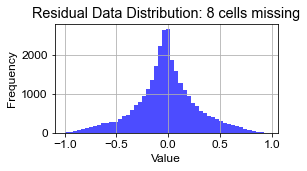

In [230]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

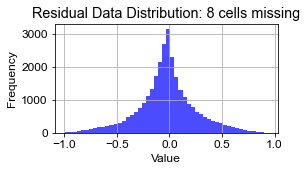

In [231]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9987755301954253


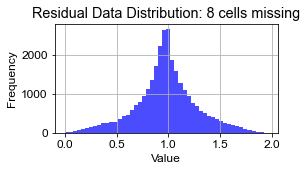

In [232]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9959977129788451


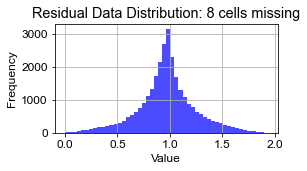

In [233]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9987755301954253


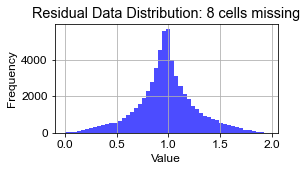

In [234]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The combined residuals (classic and dissociated)

In [235]:
#nmf on residual 1
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=20000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_combo = res_nmf_df
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,0.079100,0.154266,0.131700,0.140752,0.098491,0.141849,0.105935,0.132153,0.168867,0.151931,...,0.119536,0.049234,0.115687,0.091013,0.110671,0.119553,0.113877,0.124193,0.150031,0.165609
1,0.067978,0.173494,0.127034,0.119703,0.142381,0.152277,0.196425,0.115601,0.204891,0.107458,...,0.111084,0.041539,0.096901,0.073069,0.141831,0.128916,0.100666,0.148744,0.193964,0.059432
2,0.094607,0.127865,0.118748,0.141241,0.193757,0.140246,0.070162,0.121971,0.045440,0.054778,...,0.130868,0.047206,0.096184,0.100192,0.114438,0.266504,0.105026,0.146560,0.140798,0.193913
3,0.083354,0.141296,0.130409,0.161370,0.117018,0.140678,0.159602,0.113847,0.131420,0.149430,...,0.117906,0.021752,0.103309,0.085197,0.129416,0.145193,0.102356,0.123195,0.131472,0.126714


In [236]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic       P-Value
0        0.0     0.059142  9.536749e-01
1        1.0     0.896442  3.851722e-01
2        2.0    -9.224504  2.514633e-07
3        3.0     0.860779  4.038611e-01
Components with significantly different means:
   Component  T-Statistic       P-Value
2        2.0    -9.224504  2.514633e-07


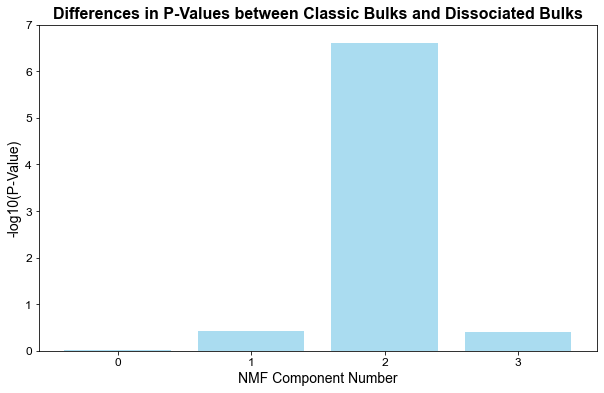

In [237]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='skyblue', alpha=0.7)

plt.xlabel('NMF Component Number', fontsize=14, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=14, fontname='Arial')
plt.title('Differences in P-Values between Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3])
plt.ylim(0,7)
plt.show()

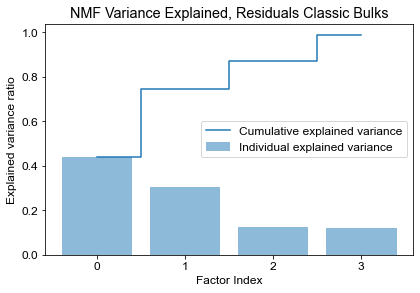

In [238]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]


## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [239]:
W = res_nmf_combo.values
H = components_combo.values

comp_genes = dict()
num_components = num_nmf_comp_combo
# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['LAMA4', 'CFI', 'NBEAL2', 'EHF', 'NLRC5', 'TTN', 'BTN3A1', 'TAP2',
       'CIITA', 'LY75'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['SLC11A2', 'TFCP2L1', 'LGR4', 'SCRN1', 'TSC2', 'CEP192', 'NR2C2',
       'PLEKHG3', 'PTPRS', 'VTCN1'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['YOD1', 'IL1B', 'LIF', 'AC253572.2', 'ZC3H12A', 'EPHA2', 'DUSP2',
       'KLHL21', 'KRT17', 'NLRP3'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['SLCO2B1', 'SLC7A2', 'NDST1', 'PTPRF', 'PTPRS', 'TBC1D16', 'TTN',
       'GPAM', 'PLXNA4', 'TLN2'],
      dtype='object')


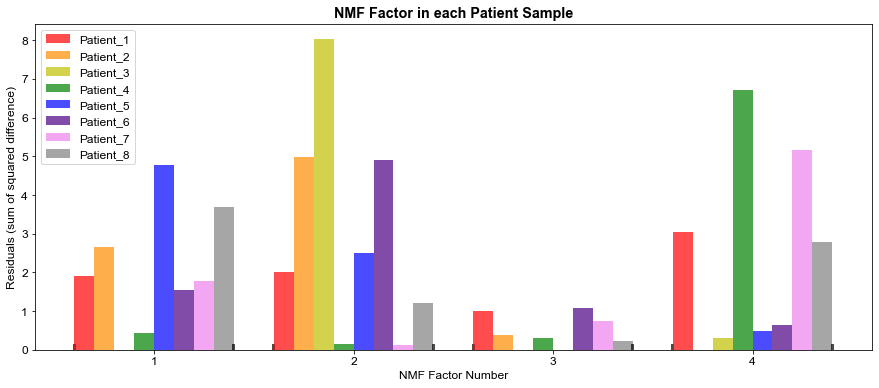

In [240]:
pt1_values = res_nmf_combo.loc[0].values
pt2_values = res_nmf_combo.loc[1].values
pt3_values = res_nmf_combo.loc[2].values
pt4_values = res_nmf_combo.loc[3].values
pt5_values = res_nmf_combo.loc[4].values
pt6_values = res_nmf_combo.loc[5].values
pt7_values = res_nmf_combo.loc[6].values
pt8_values = res_nmf_combo.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

Now dissociated bulks:

In [241]:
#nmf on residual 1
num_nmf = 5
nmf = NMF(n_components = num_nmf, init="nndsvd", max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_dissbulks_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_dissbulks = res_nmf_df
components_dissbulks = pd.DataFrame(nmf.components_)
components_dissbulks.columns = gene_ids
components_dissbulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,0.086158,0.180611,0.150276,0.160130,0.145213,0.170166,0.141067,0.139358,0.148401,0.110721,...,0.134497,0.055101,0.113638,0.100306,0.153458,0.217893,0.125278,0.171695,0.190996,0.139595
1,0.061900,0.116654,0.088473,0.086730,0.165975,0.107325,0.132560,0.087435,0.124149,0.078321,...,0.089878,0.023835,0.072326,0.064557,0.086713,0.133979,0.071700,0.097817,0.144739,0.076263
2,0.038797,0.073832,0.061829,0.067839,0.051563,0.071323,0.047812,0.055104,0.057109,0.066035,...,0.059708,0.014507,0.051199,0.045446,0.059089,0.097639,0.050918,0.048723,0.057845,0.075962
3,0.082700,0.124085,0.117546,0.145008,0.141426,0.129802,0.121859,0.111656,0.125914,0.105262,...,0.121777,0.034732,0.097176,0.079597,0.112150,0.144309,0.095770,0.118930,0.126479,0.156043
4,0.068526,0.093227,0.081687,0.108020,0.095104,0.095015,0.104193,0.097333,0.091272,0.108020,...,0.081615,0.031040,0.086077,0.066625,0.076525,0.063838,0.077596,0.099676,0.106344,0.135286


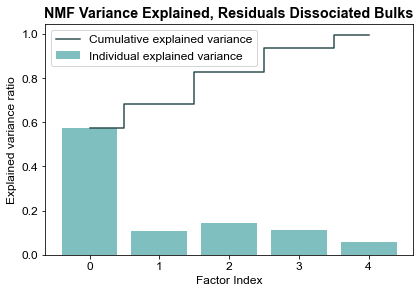

In [242]:
# W and H are your NMF results
V = residuals_dissbulks_shift.values
W = res_nmf_dissbulks.values
H = components_dissbulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Dissociated Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [243]:
num_components = 5
W = res_nmf_dissbulks.values
H = components_dissbulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_dissbulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['PLEKHG3', 'ITGA3', 'LAMB3', 'TFCP2L1', 'PTPRS', 'TSC2', 'NISCH',
       'LDB1', 'NBEAL2', 'SEC24C'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['PFKFB2', 'ATP6V1B2', 'CRY2', 'ARHGAP4', 'NFKBID', 'AC116366.1',
       'SPHK1', 'SCARA3', 'CSF3R', 'NECTIN4'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['TNC', 'DUSP4', 'ITGAL', 'SPOCK2', 'SLC40A1', 'PSD4', 'NUP210', 'CSF1',
       'CHI3L1', 'THSD4'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['ITPR3', 'ITGA3', 'TTN', 'PTPRF', 'CLDN1', 'PPL', 'S1PR1', 'MFSD2A',
       'ITGB4', 'SLC7A2'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['WT1', 'TAP2', 'RASSF4', 'KLK8', 'BIRC3', 'FDFT1', 'CIITA', 'MICAL1',
       'SLCO2B1', 'KLK7'],
      dtype='object')


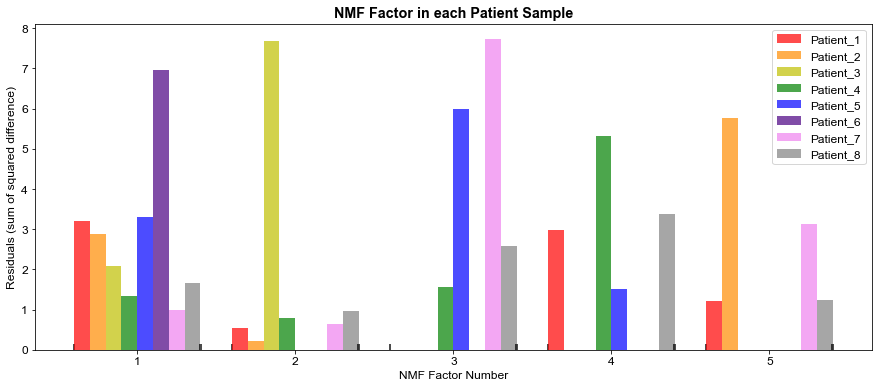

In [244]:
pt1_values = res_nmf_dissbulks.loc[0].values
pt2_values = res_nmf_dissbulks.loc[1].values
pt3_values = res_nmf_dissbulks.loc[2].values
pt4_values = res_nmf_dissbulks.loc[3].values
pt5_values = res_nmf_dissbulks.loc[4].values
pt6_values = res_nmf_dissbulks.loc[5].values
pt7_values = res_nmf_dissbulks.loc[6].values
pt8_values = res_nmf_dissbulks.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

And Classic Bulks

In [245]:
#NMF Residual(by sample) of bulks
num_nmf = 5
nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
res_nmf_df = nmf.fit_transform(residuals_bulks_shift)
components_bulks = nmf.components_
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_bulks = res_nmf_df
components_bulks = pd.DataFrame(components_bulks)
components_bulks.columns = gene_ids
components_bulks

,A1BG,A2M,AAGAB,AASS,AATK,ABCA1,ABCA5,ABCB1,ABCC4,ABCE1,...,ZNF92,ZNHIT1,ZNHIT3,ZNRD2,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZXDC,ZYX
0,0.067364,0.153129,0.122908,0.119551,0.121820,0.138984,0.125576,0.111514,0.202431,0.145568,...,0.109706,0.040597,0.100041,0.076591,0.108715,0.119395,0.099036,0.092218,0.165553,0.103990
1,0.076369,0.119571,0.114335,0.144531,0.100507,0.124371,0.129803,0.096734,0.092476,0.136275,...,0.100750,0.014177,0.089334,0.077145,0.113435,0.146950,0.089531,0.104200,0.105357,0.107600
2,0.044436,0.115384,0.077286,0.075396,0.089996,0.100855,0.156425,0.073710,0.131436,0.071781,...,0.072440,0.021940,0.064461,0.047489,0.101077,0.082337,0.062414,0.091892,0.128711,0.038044
3,0.058648,0.132871,0.108995,0.104604,0.105675,0.122987,0.107315,0.095928,0.144751,0.072396,...,0.090086,0.042279,0.076960,0.059108,0.107349,0.113137,0.086631,0.137297,0.135183,0.060158
4,0.074012,0.125840,0.112185,0.130911,0.103254,0.112792,0.115953,0.123807,0.097518,0.105034,...,0.113445,0.037360,0.100692,0.087457,0.098545,0.119548,0.099081,0.141018,0.126508,0.186989


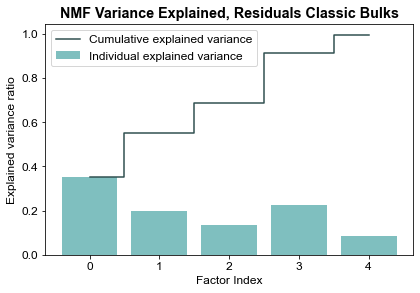

In [246]:
# W and H are your NMF results
V = residuals_bulks_shift.values
W = res_nmf_bulks.values
H = components_bulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]


## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [247]:
num_components = 5
W = res_nmf_bulks.values
H = components_bulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(0,5):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['SULF1', 'ITGB4', 'OSMR', 'TMEM164', 'THSD4', 'CIITA', 'ERAP2', 'TBCD',
       'TAP2', 'LY75'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['SLCO2B1', 'PRKAR2B', 'PTPRF', 'SLC7A2', 'TTN', 'TLN2', 'LIPE', 'SAA1',
       'PLXNA4', 'GPAM'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['ABCA5', 'ANPEP', 'HSPA12A', 'PLEKHA7', 'OTUD7B', 'GLI3', 'TFCP2L1',
       'CLCN5', 'B4GALNT3', 'TSNARE1'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['TTN', 'TSC2', 'KANSL3', 'SCRN1', 'CD163', 'CIC', 'LAMA3', 'CEP192',
       'LAMB3', 'PPL'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['TGFBR1', 'PTGIS', 'AKNA', 'ITGB4', 'IL7R', 'WDFY4', 'ANKH', 'PDLIM3',
       'THEMIS2', 'RASSF2'],
      dtype='object')


In [248]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic       P-Value
0        0.0     0.059142  9.536749e-01
1        1.0     0.896442  3.851722e-01
2        2.0    -9.224504  2.514633e-07
3        3.0     0.860779  4.038611e-01
Components with significantly different means:
   Component  T-Statistic       P-Value
2        2.0    -9.224504  2.514633e-07


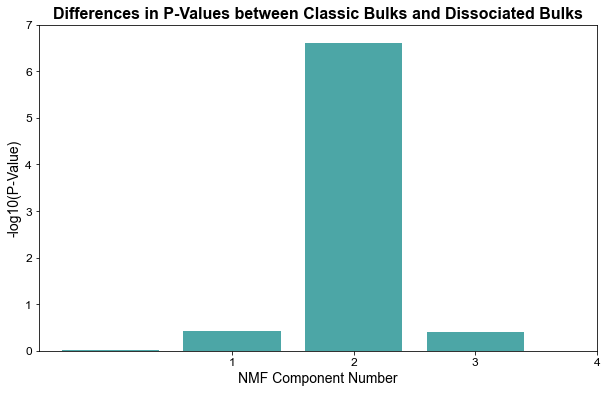

In [249]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.7)

plt.xlabel('NMF Component Number', fontsize=14, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=14, fontname='Arial')
plt.title('Differences in P-Values between Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.xticks([1,2,3,4])
plt.ylim(0,7)
plt.show()

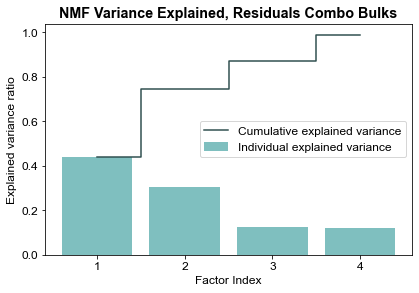

In [250]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2] ]



## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.xticks([1,2,3,4])
plt.title(f"NMF Variance Explained, Residuals Combo Bulks", fontweight='bold', fontname="Arial")
plt.show()

Now dissociated bulks:

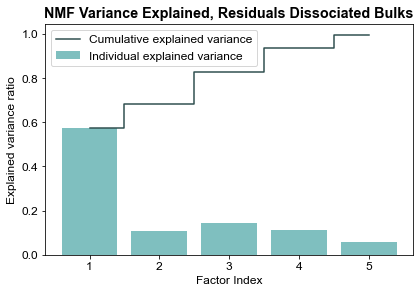

In [251]:
# W and H are your NMF results
V = residuals_dissbulks_shift.values
W = res_nmf_dissbulks.values
H = components_dissbulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Dissociated Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [252]:
num_components = 5
W = res_nmf_dissbulks.values
H = components_dissbulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_dissbulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['PLEKHG3', 'ITGA3', 'LAMB3', 'TFCP2L1', 'PTPRS', 'TSC2', 'NISCH',
       'LDB1', 'NBEAL2', 'SEC24C'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['PFKFB2', 'ATP6V1B2', 'CRY2', 'ARHGAP4', 'NFKBID', 'AC116366.1',
       'SPHK1', 'SCARA3', 'CSF3R', 'NECTIN4'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['TNC', 'DUSP4', 'ITGAL', 'SPOCK2', 'SLC40A1', 'PSD4', 'NUP210', 'CSF1',
       'CHI3L1', 'THSD4'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['ITPR3', 'ITGA3', 'TTN', 'PTPRF', 'CLDN1', 'PPL', 'S1PR1', 'MFSD2A',
       'ITGB4', 'SLC7A2'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['WT1', 'TAP2', 'RASSF4', 'KLK8', 'BIRC3', 'FDFT1', 'CIITA', 'MICAL1',
       'SLCO2B1', 'KLK7'],
      dtype='object')


And Classic Bulks

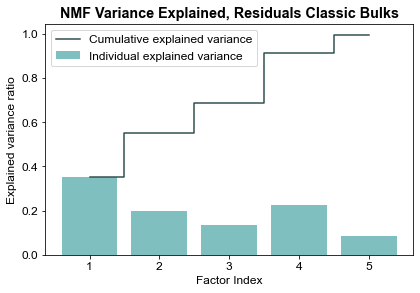

In [253]:
# W and H are your NMF results
V = residuals_bulks_shift.values
W = res_nmf_bulks.values
H = components_bulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]


## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [254]:
num_components = 5
W = res_nmf_bulks.values
H = components_bulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(0,5):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['SULF1', 'ITGB4', 'OSMR', 'TMEM164', 'THSD4', 'CIITA', 'ERAP2', 'TBCD',
       'TAP2', 'LY75'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['SLCO2B1', 'PRKAR2B', 'PTPRF', 'SLC7A2', 'TTN', 'TLN2', 'LIPE', 'SAA1',
       'PLXNA4', 'GPAM'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['ABCA5', 'ANPEP', 'HSPA12A', 'PLEKHA7', 'OTUD7B', 'GLI3', 'TFCP2L1',
       'CLCN5', 'B4GALNT3', 'TSNARE1'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['TTN', 'TSC2', 'KANSL3', 'SCRN1', 'CD163', 'CIC', 'LAMA3', 'CEP192',
       'LAMB3', 'PPL'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['TGFBR1', 'PTGIS', 'AKNA', 'ITGB4', 'IL7R', 'WDFY4', 'ANKH', 'PDLIM3',
       'THEMIS2', 'RASSF2'],
      dtype='object')


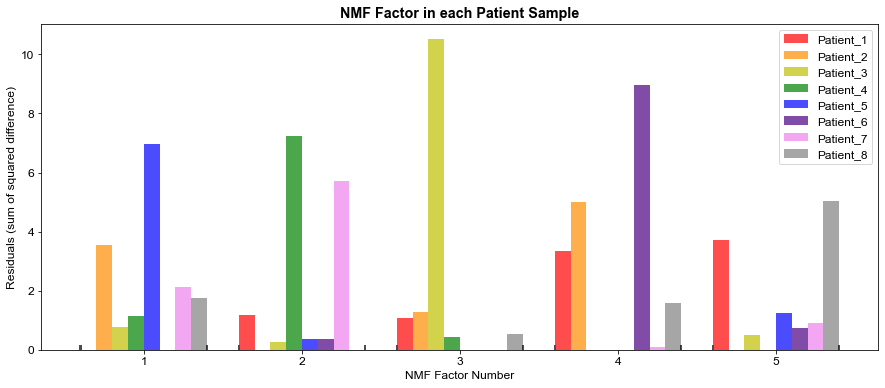

In [255]:
pt1_values = res_nmf_bulks.loc[0].values
pt2_values = res_nmf_bulks.loc[1].values
pt3_values = res_nmf_bulks.loc[2].values
pt4_values = res_nmf_bulks.loc[3].values
pt5_values = res_nmf_bulks.loc[4].values
pt6_values = res_nmf_bulks.loc[5].values
pt7_values = res_nmf_bulks.loc[6].values
pt8_values = res_nmf_bulks.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

In [256]:
top_residual_bulks= dict()
for num in range(8):
    # Assuming your matrix is named 'gene_expression_matrix' and is a numpy array or a pandas DataFrame
    # Replace 'gene_expression_matrix' with the actual name of your matrix

    # Extract the third row
    third_row = residuals_bulks.values[num, :]  # Note: Python uses 0-based indexing, so the third row is at index 2

    # Get the indices of the top 10 genes with the highest expression
    top_10_genes_indices = np.argsort(third_row)[::-1][:15]

    # Extract the gene names corresponding to the top 10 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  # Replace 'your_gene_names' with the actual names of your genes

    print(f"Top 10 most expressed genes in the {num}sample:")
    for gene_name in gene_names_top_10:
        print(gene_name)
    top_residual_bulks[num] = gene_names_top_10    


Top 10 most expressed genes in the 0sample:
NBEAL2
TTN
CD163
DENND11
TBC1D16
SEC24C
CD93
NISCH
TSC2
CLSTN3
PTPRS
DGCR2
THEMIS2
ITGA3
PPL
Top 10 most expressed genes in the 1sample:
AC136475.3
MIRLET7BHG
LY75
CIITA
TENM4
PVR
ARHGAP8
PPARA
NBEAL2
NR2C2
CEP192
DENND11
IKBKB
DIP2A
SLC12A7
Top 10 most expressed genes in the 2sample:
B4GALNT3
TSNARE1
CLCN5
TFCP2L1
OTUD7B
LDB1
COL27A1
TMEM164
NUP210
HSPA12A
NBEAL2
ANPEP
PLEKHG3
GLI3
PLEKHA7
Top 10 most expressed genes in the 3sample:
GPAM
LIPE
TTN
PLXNA4
TNFSF14
PTPRF
SLCO2B1
PPL
STAT5A
MUC16
TBC1D16
AKR1C1
ARHGEF6
PTPRS
KANK1
Top 10 most expressed genes in the 4sample:
NUP210
LY75
NBEAL2
PTPRS
NEO1
LAMA4
TMEM164
ITGB4
PSD4
OSMR
ITGA3
MYLK
TBCD
EFTUD2
NISCH
Top 10 most expressed genes in the 5sample:
TTN
SRC
NBEAL2
CD163
PLEKHG3
PPL
CEP192
LAMB3
SEC24C
SDC1
PTPRS
NISCH
PLXNA2
MYH14
CIC
Top 10 most expressed genes in the 6sample:
GPAM
TTN
PTPRF
ITPR3
PTPRS
NBEAL2
MUC16
HEATR1
SLCO2B1
COL27A1
IL7R
SAA1
PLXNA4
RASSF2
NDST1
Top 10 most expressed 

In [257]:
# Extract the third row
num = 2
third_row = residuals_bulks.values[num, :]  # Note: Python uses 0-based indexing, so the third row is at index 2

# Get the indices of the top 10 genes with the highest expression
top_10_genes_indices = np.argsort(third_row)[::-1][:10]

# Extract the gene names corresponding to the top 10 indices
gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  # Replace 'your_gene_names' with the actual names of your genes

print(f"Top 10 most expressed genes in the {num}sample:")
for gene_name in gene_names_top_10:
    print(gene_name)

Top 10 most expressed genes in the 2sample:
B4GALNT3
TSNARE1
CLCN5
TFCP2L1
OTUD7B
LDB1
COL27A1
TMEM164
NUP210
HSPA12A


In [167]:
vp.make_prop_table(adata_7, "cell_types")

,Cell_Types,Num_Cells,Prop_Cells
0,Monocytes,100,0.041806
1,B cells,21,0.008779
2,T cells,592,0.247492
3,Epithelial cells,272,0.113712
4,Endothelial cells,274,0.114548
5,Fibroblasts,467,0.195234
6,Plasma cells,357,0.149247
7,Macrophages,206,0.086120
8,Mast cells,24,0.010033
9,NK cells,61,0.025502
